In [ ]:
# The MIT License (MIT)

# Copyright (c) 2020, NVIDIA CORPORATION.

# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE

# Tutorial: Feature Engineering for Recommender Systems

# 4. Feature Engineering - Numerical

## 4.2. Normalization

In [1]:
import IPython

import pandas as pd
import cudf
import numpy as np
import cupy
import matplotlib.pyplot as plt

df_train = cudf.read_parquet('./data/train.parquet')
df_valid = cudf.read_parquet('./data/valid.parquet')
df_test = cudf.read_parquet('./data/test.parquet')

df_train['brand'] = df_train['brand'].fillna('UNKNOWN')
df_valid['brand'] = df_valid['brand'].fillna('UNKNOWN')
df_test['brand'] = df_test['brand'].fillna('UNKNOWN')

df_train['cat_0'] = df_train['cat_0'].fillna('UNKNOWN')
df_valid['cat_0'] = df_valid['cat_0'].fillna('UNKNOWN')
df_test['cat_0'] = df_test['cat_0'].fillna('UNKNOWN')

df_train['cat_1'] = df_train['cat_1'].fillna('UNKNOWN')
df_valid['cat_1'] = df_valid['cat_1'].fillna('UNKNOWN')
df_test['cat_1'] = df_test['cat_1'].fillna('UNKNOWN')

df_train['cat_2'] = df_train['cat_2'].fillna('UNKNOWN')
df_valid['cat_2'] = df_valid['cat_2'].fillna('UNKNOWN')
df_test['cat_2'] = df_test['cat_2'].fillna('UNKNOWN')

We generate some numerical features with the feature engineering from the previous notebooks.

In [2]:
def target_encode(train, valid, col, target, kfold=5, smooth=20, gpu=True):
    """
        train:  train dataset
        valid:  validation dataset
        col:   column which will be encoded (in the example RESOURCE)
        target: target column which will be used to calculate the statistic
    """
    
    # We assume that the train dataset is shuffled
    train['kfold'] = ((train.index) % kfold)
    # We keep the original order as cudf merge will not preserve the original order
    if gpu:
        train['org_sorting'] = cupy.arange(len(train), dtype="int32")
    else:
        train['org_sorting'] = np.arange(len(train), dtype="int32")
    # We create the output column, we fill with 0
    col_name = '_'.join(col)
    train['TE_' + col_name] = 0.
    for i in range(kfold):
        ###################################
        # filter for out of fold
        # calculate the mean/counts per group category
        # calculate the global mean for the oof
        # calculate the smoothed TE
        # merge it to the original dataframe
        ###################################
        
        df_tmp = train[train['kfold']!=i]
        mn = df_tmp[target].mean()
        df_tmp = df_tmp[col + [target]].groupby(col).agg(['mean', 'count']).reset_index()
        df_tmp.columns = col + ['mean', 'count']
        df_tmp['TE_tmp'] = ((df_tmp['mean']*df_tmp['count'])+(mn*smooth)) / (df_tmp['count']+smooth)
        df_tmp_m = train[col + ['kfold', 'org_sorting', 'TE_' + col_name]].merge(df_tmp, how='left', left_on=col, right_on=col).sort_values('org_sorting')
        df_tmp_m.loc[df_tmp_m['kfold']==i, 'TE_' + col_name] = df_tmp_m.loc[df_tmp_m['kfold']==i, 'TE_tmp']
        train['TE_' + col_name] = df_tmp_m['TE_' + col_name].fillna(mn).values

    
    ###################################
    # calculate the mean/counts per group for the full training dataset
    # calculate the global mean
    # calculate the smoothed TE
    # merge it to the original dataframe
    # drop all temp columns
    ###################################    
    
    df_tmp = train[col + [target]].groupby(col).agg(['mean', 'count']).reset_index()
    mn = train[target].mean()
    df_tmp.columns = col + ['mean', 'count']
    df_tmp['TE_tmp'] = ((df_tmp['mean']*df_tmp['count'])+(mn*smooth)) / (df_tmp['count']+smooth)
    if gpu:
        valid['org_sorting'] = cupy.arange(len(valid), dtype="int32")
    else:
        valid['org_sorting'] = np.arange(len(valid), dtype="int32")
    df_tmp_m = valid[col + ['org_sorting']].merge(df_tmp, how='left', left_on=col, right_on=col).sort_values('org_sorting')
    valid['TE_' + col_name] = df_tmp_m['TE_tmp'].fillna(mn).values
    
    valid = valid.drop('org_sorting', axis=1)
    train = train.drop('kfold', axis=1)
    train = train.drop('org_sorting', axis=1)
    return(train, valid)

In [3]:
df_train.columns

Index(['event_time', 'event_type', 'product_id', 'brand', 'price', 'user_id',
       'user_session', 'target', 'cat_0', 'cat_1', 'cat_2', 'cat_3',
       'timestamp', 'ts_hour', 'ts_minute', 'ts_weekday', 'ts_day', 'ts_month',
       'ts_year'],
      dtype='object')

In [4]:
cats = [['cat_0'], ['cat_1'], ['cat_2'], ['cat_0', 'cat_1', 'cat_2'], ['ts_hour'], ['ts_weekday'], ['ts_weekday', 'ts_hour', 'cat_2', 'brand']]

In [5]:
for cat in cats:
    df_train, df_valid = target_encode(df_train, df_valid, cat, 'target')

In [6]:
cats = ['brand', 'user_id', 'product_id', 'cat_0', 'cat_1', 'cat_2']

In [7]:
def count_encode(train, valid, col, gpu=True):
    """
        train:  train dataset
        valid:  validation dataset
        col:    column which will be count encoded (in the example RESOURCE)
    """
    # We keep the original order as cudf merge will not preserve the original order
    if gpu:
        train['org_sorting'] = cupy.arange(len(train), dtype="int32")
    else:
        train['org_sorting'] = np.arange(len(train), dtype="int32")
    
    train_tmp = train[col].value_counts().reset_index()
    train_tmp.columns = [col,  'CE_' + col]
    df_tmp = train[[col, 'org_sorting']].merge(train_tmp, how='left', left_on=col, right_on=col).sort_values('org_sorting')
    train['CE_' + col] = df_tmp['CE_' + col].fillna(0).values
        
    if gpu:
        valid['org_sorting'] = cupy.arange(len(valid), dtype="int32")
    else:
        valid['org_sorting'] = np.arange(len(valid), dtype="int32")
    df_tmp = valid[[col, 'org_sorting']].merge(train_tmp, how='left', left_on=col, right_on=col).sort_values('org_sorting')
    valid['CE_' + col] = df_tmp['CE_' + col].fillna(0).values
    
    valid = valid.drop('org_sorting', axis=1)
    train = train.drop('org_sorting', axis=1)
    return(train, valid)

In [8]:
%%time

for cat in cats:
    df_train, df_valid = count_encode(df_train, df_valid, cat, gpu=True)

CPU times: user 648 ms, sys: 1.26 s, total: 1.91 s
Wall time: 1.91 s


In [9]:
df_train.head()

,event_time,event_type,product_id,brand,price,user_id,user_session,target,cat_0,cat_1,...,TE_cat_0_cat_1_cat_2,TE_ts_hour,TE_ts_weekday,TE_ts_weekday_ts_hour_cat_2_brand,CE_brand,CE_user_id,CE_product_id,CE_cat_0,CE_cat_1,CE_cat_2
0,2019-12-01 00:00:28 UTC,cart,17800342,zeta,66.90,550465671,22650a62-2d9c-4151-9f41-2674ec6d32d5,0,computers,desktop,...,0.280155,0.305423,0.410060,0.301241,10859,9,743,372964,51652,5058060
1,2019-12-01 00:00:39 UTC,cart,3701309,polaris,89.32,543733099,a65116f4-ac53-4a41-ad68-6606788e674c,0,appliances,environment,...,0.350069,0.305249,0.410061,0.333539,50273,56,12,1527338,287043,213674
2,2019-12-01 00:00:40 UTC,cart,3701309,polaris,89.32,543733099,a65116f4-ac53-4a41-ad68-6606788e674c,0,appliances,environment,...,0.351989,0.305235,0.410059,0.319065,50273,56,12,1527338,287043,213674
3,2019-12-01 00:00:41 UTC,cart,3701309,polaris,89.32,543733099,a65116f4-ac53-4a41-ad68-6606788e674c,0,appliances,environment,...,0.351410,0.305370,0.410061,0.333539,50273,56,12,1527338,287043,213674
4,2019-12-01 00:01:56 UTC,cart,1004767,samsung,235.60,579970209,c6946211-ce70-4228-95ce-fd7fccdde63c,0,construction,tools,...,0.460389,0.305449,0.410061,0.466269,2323417,9,317711,3363367,3307872,3172781


In [10]:
df_train.columns

Index(['event_time', 'event_type', 'product_id', 'brand', 'price', 'user_id',
       'user_session', 'target', 'cat_0', 'cat_1', 'cat_2', 'cat_3',
       'timestamp', 'ts_hour', 'ts_minute', 'ts_weekday', 'ts_day', 'ts_month',
       'ts_year', 'TE_cat_0', 'TE_cat_1', 'TE_cat_2', 'TE_cat_0_cat_1_cat_2',
       'TE_ts_hour', 'TE_ts_weekday', 'TE_ts_weekday_ts_hour_cat_2_brand',
       'CE_brand', 'CE_user_id', 'CE_product_id', 'CE_cat_0', 'CE_cat_1',
       'CE_cat_2'],
      dtype='object')

## Theory

<b>*Normalization*</b> is required to enable neural networks to leverage numerical features. Tree-based models do not require normalization as they define the split independent of the scale of a feature. Without normalization, neural networks are difficult to train. The image visualizes the loss surface and the gradient updates for non-normalized input (left) and normalized input (right). <br><br>

Source: https://www.jeremyjordan.me/batch-normalization/



<img src='./images/normalization.png' width=50%>

The reason is that different numerical features have different scales. When we combine the features in a hidden layer, the different scales make it more difficult to extract patterns from it.

## Normalization Techniques

After we outline the importance for normalizing the numerical input feature, we will discuss different strategy to achieve a normal distributed input feature:
1. Normalization with mean/std
2. Log-based normalization
3. Scale to 0-1
4. Gauss Rank (separate notebook)
5. Power transfomer

### 4.2.1 Normalization with mean/std

The most common approach is to normalize a numerical feature by substracting the mean and divide the feature by the standard derviation:

\begin{equation} \label{eq:normalize}
X_{norm} = \frac{X - mean_{X}}{\sigma_{X}} \sim \mathcal{N}(0,\,1)\,
\end{equation}

In [11]:
X = df_train['CE_product_id']

In [12]:
X_norm = (X-X.mean())/X.std()

Our features does not follow a normal distribution

Text(0.5, 1.0, 'Histogram normalised')

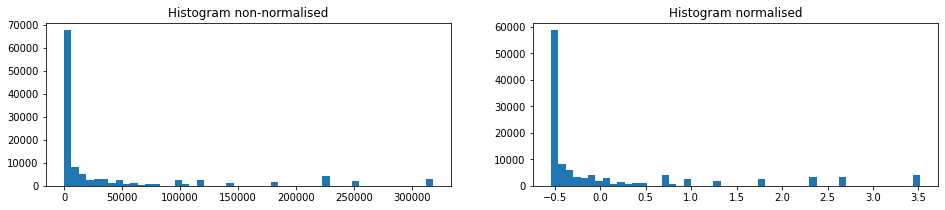

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(16,3))
axs[0].hist(X.sample(frac=0.01).to_pandas(), bins=50)
axs[0].set_title('Histogram non-normalised')
axs[1].hist(X_norm.sample(frac=0.01).to_pandas(), bins=50)
axs[1].set_title('Histogram normalised')

### 4.2.2 Log-based normalization

Some features are not normal distributed in the raw format. If they have a long-tail distribution, we can normalize them by applying the log function, first.

\begin{equation} \label{eq:log}
X_{log} = log(X+1) \\
X_{log-norm} = \frac{X_{log} - mean_{X_{log}}}{\sigma_{X_{log}}} \sim \mathcal{N}(0,\,1)\,
\end{equation}

User behavior data have often a long-tail distribution, such as # of clicks or # of purchases.

In [14]:
X = df_train['CE_product_id'].to_pandas()

In [15]:
X_log = np.log(X+1)

In [16]:
X_norm = (X_log-X_log.mean())/X_log.std()

Text(0.5, 1.0, 'Histogram normalised')

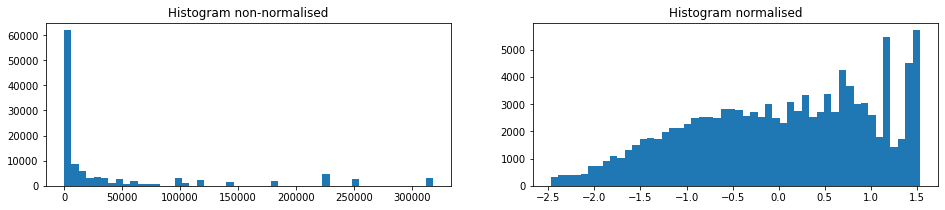

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(16,3))
axs[0].hist(X.sample(frac=0.01), bins=50)
axs[0].set_title('Histogram non-normalised')
axs[1].hist(X_norm.sample(frac=0.01), bins=50)
axs[1].set_title('Histogram normalised')

### 4.2.3 Scale to 0-1

Another technique is to scale the numerical features between 0-1.

\begin{equation} \label{eq:01}
X_{norm} = \frac{X - min(X)}{max(X)-min(X)}
\end{equation}

In [18]:
X = df_train['TE_cat_2']

(array([8.0000e+00, 8.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        3.2000e+01, 9.2000e+01, 1.5600e+02, 1.4000e+01, 4.9000e+01,
        3.4800e+02, 9.1000e+01, 1.0510e+03, 1.1800e+02, 1.7700e+02,
        1.4710e+03, 1.1560e+03, 3.5200e+02, 7.2900e+02, 3.4340e+03,
        4.7980e+04, 1.9500e+03, 1.0770e+03, 4.4340e+03, 3.4220e+03,
        2.9400e+02, 3.6550e+03, 0.0000e+00, 3.5900e+02, 1.6090e+03,
        2.5380e+03, 9.9100e+02, 2.3800e+02, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.7500e+02, 0.0000e+00, 3.4905e+04, 8.4600e+02,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.5400e+02]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.

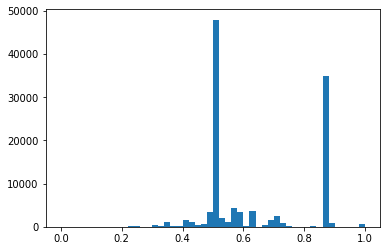

In [19]:
plt.hist(((X-X.min())/(X.max()-X.min())).sample(frac=0.01).to_pandas(), bins=50)

## Practice

Now, it is your turn.<br><br>

**ToDo**:
<li>Normalize the features: price, TE_ts_weekday_ts_hour_cat_2_brand, CE_cat_2<br>
<li>Which normalization technique seems good?

In [20]:
### ToDo

Optimisation is skipped

We shutdown the kernel.

In [25]:
app = IPython.Application.instance()
app.kernel.do_shutdown(False)

{'status': 'ok', 'restart': False}